# Entrenando modelo para reconocer palabras

### Obteniendo los comandos iniciales

In [ ]:
#----------------------------------------------------------------------------------
#--------------------------------
#   Speech data aquisition
#----------------------------------------------------------------------------------
#--------------------------------
import time
import random
import numpy as np
import sounddevice as sd
import pickle
from datetime import datetime
# Experiment configuration
conditions = [('Escuela', 1), ('Trabajo', 2), ('Casa', 3), ('Boliche', 4), ('Bar', 5)]
n_trials = 30
fixation_cross_time = 2
preparation_time = 0.3
training_time = 2
rest_time = 1
trials = n_trials*conditions
random.shuffle(trials)
fs=44100    
# Data aquisition
data = []
for i,t in enumerate(trials):
    # Fixation cross
    print ("*********")    
    time.sleep(fixation_cross_time)    
    
    # Preparation time
    print (t[0])
    time.sleep(preparation_time)
    # Task    
    recording = sd.rec(training_time * fs, samplerate=fs, 
channels=2,dtype='float64')    
    sd.wait()
    data.append((t[0], t[1], recording))
    # Rest time
    print(f"----Descansa---- {len(trials) - i - 1} left. ")
    time.sleep(rest_time)
# Play records
for t in data:
    sd.play(t[2], fs)
    sd.wait()
# Save data
outputFile = open('JORGE.obj', 'wb')
pickle.dump(data, outputFile)
outputFile.close()
#----------------------------------------------------------------------------------
#--------------------------------
#   End of file
#----------------------------------------------------------------------------------

### obtener la matriz de features

In [1]:
import pickle
import numpy as np
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import sounddevice as sd
from python_speech_features import mfcc

def process_voice_commands(file_name):
    #----------------------------------------------------------------------------------
    #--------------------------------
    #   Speech data processing
    #----------------------------------------------------------------------------------
    #--------------------------------



    # Load audio records
    fs = 44100
    inputFile = open(file_name, 'rb')
    data = pickle.load(inputFile)
    n_trials = len(data)
    # Plot one record
    t = 5
    dt = 1/fs
    t_size = data[t][2].shape[0]
    x = np.arange(0, t_size*dt, dt)
    figure, axis = plt.subplots(2, 1)
    axis[0].plot(x, data[t][2][:,0])
    axis[0].set_title("Canal 1")
    axis[1].plot(x, data[t][2][:,1])
    axis[1].set_title("Canal 2")
    plt.show()
    # Filter signals
    filt = signal.iirfilter(4, [10, 15000], rs=60, btype='band',
                           analog=False, ftype='cheby2', fs=fs,
                           output='ba')
    filtered = []
    for tr in data:
        ff1 = signal.filtfilt(filt[0], filt[1], tr[2][:,0], method='gust')
        ff2 = signal.filtfilt(filt[0], filt[1], tr[2][:,1], method='gust')
        filtered.append(np.column_stack((ff1, ff2)))
    figure, axis = plt.subplots(2, 1)
    axis[0].plot(x, filtered[t][:,0])
    axis[0].set_title("Canal 1")
    axis[1].plot(x, filtered[t][:,1])
    axis[1].set_title("Canal 2")
    plt.show()
    sd.play(filtered[t], fs)
    sd.wait()
    sd.play(data[t][2], fs)
    sd.wait()
    # Calculate MFCC features
    mfcc_feat = mfcc(filtered[t], fs, nfft = 2048)
    plt.matshow(mfcc_feat.T)
    plt.show()
    features = []
    for tr in data:
        mfcc_feat = mfcc(tr[2], fs, nfft = 2048)
        features.append(mfcc_feat.flatten())
    # Build x and y arrays
    x = np.array(features)
    y = [row[1] for row in data]
    
    y = np.array(y)
    #return x and y
    return x, y
    
    #----------------------------------------------------------------------------------
    #--------------------------------
    #   End of file
    #----------------------------------------------------------------------------------
    #--------------------------------

### Obteniendo modelo a usar

In [24]:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

In [21]:
def getSVC():
    return svm.SVC(kernel='linear')
def getRad():
    return svm.SVC(kernel='rbf')
def getKNN():
    return KNeighborsClassifier(n_neighbors=5)

In [22]:
modelos = {
    "SVM lineal": getSVC,
    "SVM de base radial": getRad,
    "KNN": getKNN,
}

## Obteniendo features del audio 

USANDO COMANDOS DE: JORGITO


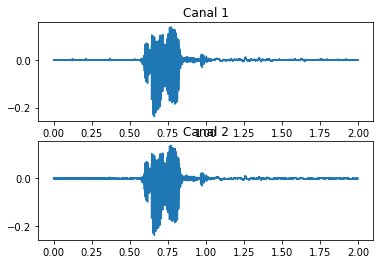

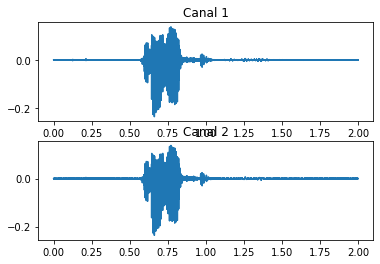

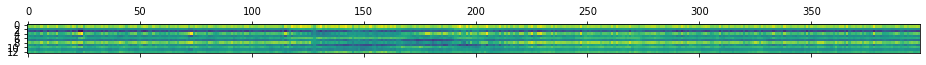

USANDO MODELO: SVM lineal
Acc:  0.8933333333333333
Recall:  0.8933333333333333
Precision:  0.8933333333333333




In [20]:
print(f"USANDO COMANDOS DE: JORGITO")
file_name = "JORGE.obj"
x, y = process_voice_commands(file_name)
model_string = "SVM lineal"
model = modelos[model_string]()
print(f"USANDO MODELO: {model_string}")
clas_results = cross_validate(model, x, y, cv = 5, scoring = ('accuracy', 'recall_micro', 'precision_micro'))
print('Acc: ', clas_results['test_accuracy'].sum()/5)
print('Recall: ', clas_results['test_recall_micro'].sum()/5)
print('Precision: ', clas_results['test_precision_micro'].sum()/5)
print()
print()

USANDO COMANDOS DE: JORGITO


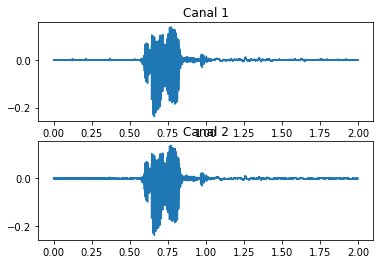

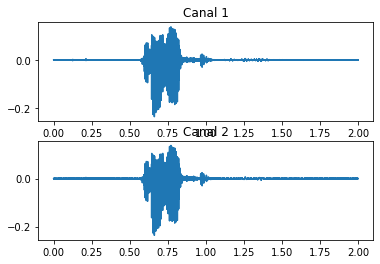

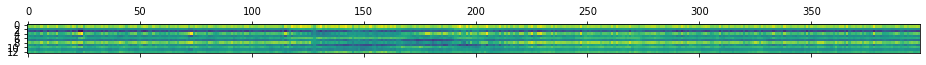

USANDO MODELO: KNN
Acc:  0.8133333333333335
Recall:  0.8133333333333335
Precision:  0.8133333333333335




In [25]:
print(f"USANDO COMANDOS DE: JORGITO")
file_name = "JORGE.obj"
x2, y2 = process_voice_commands(file_name)
model_string2 = "KNN"
model2 = modelos[model_string2]()
print(f"USANDO MODELO: {model_string2}")
clas_results = cross_validate(model2, x2, y2, cv = 5, scoring = ('accuracy', 'recall_micro', 'precision_micro'))
print('Acc: ', clas_results['test_accuracy'].sum()/5)
print('Recall: ', clas_results['test_recall_micro'].sum()/5)
print('Precision: ', clas_results['test_precision_micro'].sum()/5)
print()
print()

In [10]:
svc2 = modelos[model_string]()
svc2.fit(x,y)

SVC(kernel='linear')

In [12]:
import time
import random
import numpy as np
import sounddevice as sd
import pickle
from datetime import datetime

fs=44100
training_time = 2

r_recording = sd.rec(training_time * fs, samplerate=fs, 
channels=2,dtype='float64')
sd.wait()

sd.play(r_recording, fs)
sd.wait()

In [55]:
fs=44100
training_time = 2

r_recording2 = sd.rec(training_time * fs, samplerate=fs, 
channels=2,dtype='float64')
sd.wait()

#sd.play(r_recording2, fs)
#sd.wait()

In [56]:
current_features = []
mfcc_feat = mfcc(r_recording2, fs, nfft = 2048)
current_features.append(mfcc_feat.flatten())
x_test2 = np.array(current_features)

labels[svc2.predict(x_test2)[0]]

'Casa'

In [66]:
fs=44100
training_time = 2

r_recording2 = sd.rec(training_time * fs, samplerate=fs, 
channels=2,dtype='float64')
sd.wait()

time.sleep(1)

current_features = []
mfcc_feat = mfcc(r_recording2, fs, nfft = 2048)
current_features.append(mfcc_feat.flatten())
x_test2 = np.array(current_features)

labels[svc2.predict(x_test2)[0]]

'Escuela'

In [52]:
labels = {
    1:'Escuela',
    2:'Trabajo',
    3:'Casa',
    4:'Boliche',
    5:'Bar'
}

In [54]:
labels[svc2.predict(x_test2)[0]]

'Boliche'

In [27]:
y2

array([3, 5, 3, 3, 3, 2, 1, 1, 3, 2, 3, 3, 1, 2, 2, 1, 5, 2, 5, 1, 1, 3,
       4, 4, 5, 3, 4, 4, 1, 2, 1, 2, 2, 4, 2, 5, 1, 3, 1, 2, 5, 1, 3, 4,
       2, 4, 2, 5, 5, 1, 4, 2, 5, 4, 4, 2, 5, 1, 4, 3, 5, 4, 4, 1, 2, 4,
       5, 3, 3, 5, 3, 4, 4, 5, 2, 4, 5, 1, 1, 5, 2, 2, 4, 4, 5, 1, 3, 4,
       5, 2, 5, 1, 5, 3, 4, 2, 1, 2, 4, 3, 5, 5, 3, 4, 5, 1, 2, 2, 4, 3,
       5, 3, 5, 1, 5, 5, 4, 1, 2, 5, 3, 4, 1, 1, 1, 3, 1, 4, 2, 1, 4, 2,
       5, 1, 3, 3, 2, 3, 2, 3, 5, 3, 2, 4, 3, 1, 1, 4, 3, 2])

# Planificador de rutas

In [68]:
#Instalando librerías de open street map y de simpleAI
!python -m pip install osmnx simpleai

  Using cached osmnx-1.2.0-py2.py3-none-any.whl (92 kB)
  Using cached simpleai-0.8.3.tar.gz (94 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached requests-2.28.0-py3-none-any.whl (62 kB)
  Using cached networkx-2.8.3-py3-none-any.whl (2.0 MB)
  Using cached Shapely-1.8.2-cp39-cp39-win_amd64.whl (1.3 MB)
  Using cached pandas-1.4.2-cp39-cp39-win_amd64.whl (10.5 MB)
  Using cached pyproj-3.3.1-cp39-cp39-win_amd64.whl (6.4 MB)
  Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
  Using cached Rtree-1.0.0-cp39-cp39-win_amd64.whl (433 kB)
  Using cached Fiona-1.8.21.tar.gz (1.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [1 lines of output]
  A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
You should consider upgrading via the 'C:\TEC\OCTAVO_b\SISTEMAS\proyecto_final\2da_entrega\prueba_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [71]:
from simpleai.search import breadth_first, depth_first, SearchProblem, iterative_limited_depth_first, uniform_cost
import osmnx as ox

ModuleNotFoundError: No module named 'osmnx'

In [32]:
import osmnx as ox
from simpleai.search import breadth_first, depth_first, SearchProblem, iterative_limited_depth_first, uniform_cost


class FindRoute(SearchProblem):
    def __init__(self, goal, mapa, initial_state=(1377048890), data_cost="length"):
        self.goal = goal
        self.data_cost = data_cost
        self.__G = mapa
        super().__init__(initial_state)

    def actions(self, state):
        act = []
        (current_node) = state
        for element in self.__G.out_edges(current_node, data=self.data_cost):
            #STRUCTURE: (FROM, TO, COST)
            act.append(element)
        return act

    def result(self, state, action):
        (node_from, node_to, action_cost) = action
        return (node_to)
    
    def cost(self, state, action, state2):
        (node_from, node_to, action_cost) = action
        return action_cost

    def is_goal(self, state):
        #It finished when it arrives to the goal node
        (curr_node) = state
        return curr_node == self.goal

class RoutePlanner:
  def __init__(self, algorithm = uniform_cost):
    self.__city = 'Mexico, Guadalajara'
    self.__map = ox.graph_from_place(self.__city, network_type='drive')
    self.__starting_node = 1377048890
    self.__search_algorithm = algorithm

    self.__destinations = {
        "Escuela": 8359511705,
        "Trabajo": 1699102733,
        "Casa": 1343795278,
        "Boliche": 9795883739,
        "Bar": 1478411793
    }

  def get_route_to_destination(self, destination, color="r"):
    if destination not in self.__destinations:
      print("No existe el destino ingresado.")
      return

    destination_idx = self.__destinations[destination]
    router = FindRoute(destination_idx, mapa = self.__map, initial_state = (self.__starting_node), data_cost="length")

    route_nodes = []

    result = self.__search_algorithm(router, True)

    if not result:
      print("NO HUBO CAMINO")
    else:
      for action,state in result.path():
        if action:
            (node_from, node_to, action_cost) = action
            #total_cost += action_cost
        (node) = state
        route_nodes.append(node)

      ox.plot.plot_graph_route(self.__map, route_nodes)


ModuleNotFoundError: No module named 'osmnx'

In [ ]:
route_planner = RoutePlanner()

In [ ]:
fs=44100
training_time = 2

r_recording2 = sd.rec(training_time * fs, samplerate=fs, 
channels=2,dtype='float64')
sd.wait()

time.sleep(1)

current_features = []
mfcc_feat = mfcc(r_recording2, fs, nfft = 2048)
current_features.append(mfcc_feat.flatten())
x_test2 = np.array(current_features)

result = labels[svc2.predict(x_test2)[0]]

